# Additional assignment. Kaggle dataset. House cost prediction

This dataset is taken to practice Week1 material on linear regression.

In [274]:
import pandas as pd
import numpy as np
import scipy.stats as sts
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection as mod_sel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
initial_train_data = pd.read_csv('data/10_train.csv')
initial_test_data = pd.read_csv('data/10_test.csv')

In [3]:
initial_train_data.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1421,1422,120,RL,53.0,4043,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2010,WD,Normal,127500
1368,1369,120,RM,NaN,4435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,144000
976,977,30,RL,51.0,5900,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Normal,85500
666,667,60,RL,NaN,18450,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Abnorml,129000
294,295,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,167000


In [370]:
train_data, test_data, train_labels, test_labels = mod_sel.train_test_split(
    initial_train_data.loc[:, ['LotArea', 'OverallQual']],
    initial_train_data.loc[:, ['SalePrice']],
    test_size = 0.3, random_state=42
)

In [278]:
main_data = train_data.loc[train_data['LotArea'] < 35000]
outliers = train_data.loc[train_data['LotArea'] >= 35000]

# main_data.plot(y='LotArea', kind='hist')
# outliers.plot(y='LotArea', kind='hist')

In [279]:
def addBias(a):
    onesCol = np.ones((a.shape[0], 1))
    return np.concatenate([onesCol, a], axis=1)

In [280]:
from sklearn import preprocessing

xs = 1.0 * train_data.values
scaler = preprocessing.StandardScaler().fit(xs)

def preprocess_data(data):
    data = scaler.transform(data)
    data = preprocessing.PolynomialFeatures(3).fit_transform(data)
    return data

In [285]:
trFeatures = preprocess_data(xs)
trLabels = train_labels.values
trLogLabels = np.log(trLabels)

tsFeatures = preprocess_data(1.0 * test_data.values)
tsLabels = test_labels.values
tsLogLabels = np.log(tsLabels)

In [312]:
def predict(weights, features=trFeatures):
    return np.dot(features, weights.T)

def get_error(weights, features=trFeatures, labels=trLogLabels):
    predictions = predict(weights, features)
    
    if len(weights.shape) == 1 or weights.shape[1] == 1:
        return np.sqrt(mean_squared_error(labels, predictions))
    
    if len(labels.shape) == 1 or labels.shape[1] == 1:
        labels = np.broadcast_to(labels, predictions.shape)
    
    return np.sqrt(mean_squared_error(labels, predictions, multioutput='raw_values'))

ws = np.random.rand(3, trFeatures.shape[1])
get_error(ws)

array([ 97.17067554, 121.62713967, 171.20917491])

In [313]:
ws0 = np.random.rand(1, trFeatures.shape[1])
get_error(ws0)

res = minimize(get_error, x0=ws0) #, method='L-BFGS-B', bounds=[(-100, 100), (-5, 5)])
min_ws = res.x
print(res.fun)
print(min_ws)

tsPredictions = predict(min_ws, tsFeatures)
get_error(min_ws, features=tsFeatures, labels=tsLogLabels)

0.35637464574332395
[ 1.20644085e+01  4.16140360e-01 -6.40784259e-02  2.45537603e-03]


0.38317076747481243

In [314]:
linear_regressor = linear_model.LinearRegression()
linear_regressor = linear_regressor.fit(trFeatures, trLogLabels)

coef = linear_regressor.coef_
coef[0, 0] = linear_regressor.intercept_

get_error(coef, features=tsFeatures, labels=tsLogLabels)
coef

array([[ 1.20644109e+01,  4.16154151e-01, -6.40843282e-02,
         2.45569031e-03]])

In [472]:
from sklearn.pipeline import make_pipeline

cols = ['LotArea', 'OverallQual', 'YearBuilt', 'BuiltIn21', 'BuiltIn20', 'OverallCond', 'MSSubClass']

train_data = initial_train_data.loc[:, cols]
train_labels = initial_train_data.loc[:, ['SalePrice']]
test_data = initial_test_data.loc[:, cols]

train_data = 1.0 * train_data.values
train_labels = np.log(1.0 * train_labels.values)

linear_regressor = make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.PolynomialFeatures(3),
    linear_model.LinearRegression()
)

linear_regressor = linear_regressor.fit(train_data, train_labels)
trError = np.sqrt(mean_squared_log_error(train_labels, linear_regressor.predict(train_data)))
print(trError)

linear_scoring = mod_sel.cross_val_score(
    linear_regressor, 
#     train_data, train_labels, scoring = 'neg_mean_squared_log_error', 
    train_data, 
    train_labels,
    scoring = 'neg_mean_squared_error', 
    cv = 10
)

'{0:.4f}; {1:.4f}'.format(linear_scoring.mean(), linear_scoring.std())

0.013448712250785144


'-0.1143; 0.2051'

In [473]:
tsPredictions = linear_regressor.predict(1.0 * test_data.values)
tsPredictions = np.exp(tsPredictions)
tsPredictions = tsPredictions[:,0]

submission = pd.DataFrame({'Id': initial_test_data.Id, 'SalePrice': tsPredictions})
# you could use any filename. We choose submission here
submission.to_csv('out/10_submission.csv', index=False)

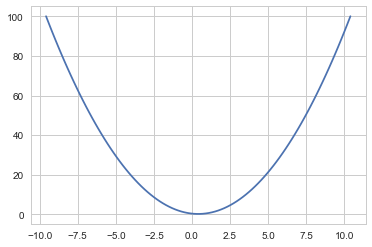

In [252]:
xs = np.linspace(min_ws[1] - 10, min_ws[1] + 10, 100)
ws_shape = (xs.shape[0], min_ws.shape[0])

ws = np.array(np.broadcast_to(min_ws, ws_shape))
ws[:, 1] = xs

ys = get_error(ws)

plt.plot(xs, ys)

In [223]:
n = 10
pr = predict(min_ws)[:n, None]
gt = trLabels[:n]

(pr - gt)/gt
# np.concatenate([gt, pr - gt, (pr - gt)/gt ], axis=1)

array([[-0.3982359 ],
       [-0.38637602],
       [-0.53257496],
       [-0.66350686],
       [-0.50315315],
       [-0.39775203],
       [-0.43587057],
       [-0.19486504],
       [-0.40873852],
       [-0.56947421]])

0.17799595559097103

In [82]:
test_data = initial_test_data.loc[:, ['LotArea']]

testFeatures = getFeatureMatrix(test_data)
testPredictions = np.exp(predict(min_ws, features=testFeatures)

submission = pd.DataFrame({'Id': initial_test_data.Id, 'SalePrice': testPredictions})
# you could use any filename. We choose submission here
submission.to_csv('out/10_submission.csv', index=False)

In [443]:
col = 'OverallCondCleared'

print(np.any(initial_train_data[col] == np.NaN))
initial_train_data[col].sample(20)

False


620     3
1036    5
640     5
412     5
269     7
530     5
282     5
623     5
30      4
463     7
483     5
16      7
738     5
1386    5
1236    5
81      5
729     5
1193    5
539     5
342     4
Name: OverallCondCleared, dtype: int64

In [458]:
def addColumns(df):
    df['BuiltIn21'] = 0
    df['BuiltIn20'] = 0

    df.loc[df['YearBuilt'] >= 2000, 'BuiltIn21'] = df['YearBuilt']
    df.loc[df['YearBuilt'] < 2000, 'BuiltIn20'] = df['YearBuilt']
    
addColumns(initial_train_data)
addColumns(initial_test_data)

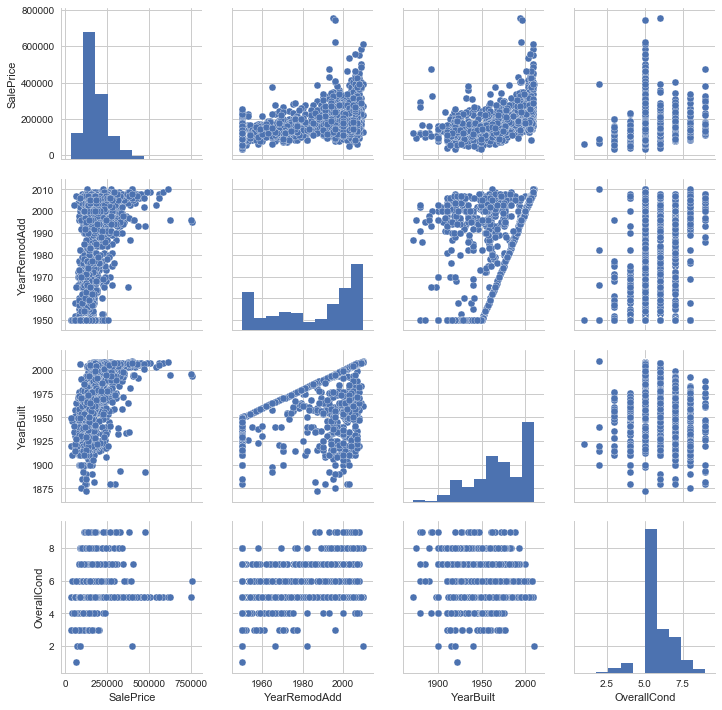

In [454]:
subdata = initial_train_data.loc[:, ['SalePrice', 'YearRemodAdd', 'YearBuilt', 'OverallCond']]

sns.pairplot(subdata)